<h1 align="center">MSIN0166: Data Engineering</h1>
<h1 align="center">Individual Assignment</h1>
<h1 align="center">Board Games and Social Media Database</h1>
<br>
<h3 align="center">May 2021</h3>

<h3>Table of Contents</h3>

* [1. Introduction](#1.-Introduction)
* [2. Data Sources](#2.-Data-Sources)
* [3. Database Schemas](#3.-Database-Schemas)
* [4. Automation Scripts](#4.-Automation-Scripts)
* [5. Machine Learning Pipeline](#5.-Machine-Learning-Pipeline)
    * [5.1 Data Preparation](#5.1-Data-Preparation)
        * [5.1.1 Data Retrieval](#5.1.1-Data-Retrieval)
        * [5.1.2 Feature Engineering](#5.1.1-Feature-Engineering)        
    * [5.2 Data Storage](#5.2-Data-Storage)
    * [5.3 Exploratory Analysis](#5.3-Exploratory-Analysis)
    * [5.4 Model Training](#5.4-Model-Training)
        * [5.4.1 Linear Regression](#5.4.1-Linear-Regression)
        * [5.4.2 Polynomial Regression](#5.4.2-Polynomial-Regression)
* [6. Conclusion](#6.-Conclusion)
* [7. Limitations](#7.-Limitations)
* [References](#References)

# Load Packages

In [1]:
import pyspark
import psycopg2
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# 1. Introduction

Board gaming has become popular for years and has suggested a considerable market in the entertainment domain. This activity enables people to play either alone, or with friends or families, and is a fascinating way to relax. What game is trending and how people reflect on it become the key factor to catch the interest of customers.

This work will gather data of the most popular board games, and people's views on a specific game on social media. Besides, a machine learning pipeline is built to gain insights about what kind of KOL (Key Opinion Leader) will contribute most to propagating a board game, which will be useful if a game wants to advertise itself by social media.

# 2. Data Sources

The data used in this work is gathered from 2 online sources, BoardGameGeek (BGG, https://boardgamegeek.com) website and Twitter.

BGG is one of the most influential communities where players can find detailed information on board games and comment on the games they have owned. BGG has a list of games which will rank all board games according to the ratings provided by plays on BGG (list url: https://boardgamegeek.com/browse/boardgame). This list suggests the most popular board games and is key to demonstrate the performance of a game.

Besides, tweets about a specific board game are scraped from Twitter through Twitter's API, as well as related bloggers' information.

# 3. Database Schemas

PostgreSQL database is chosen to store the data in this work.

In terms of the complex data structures on social media, a relational database is not a perfect approach to store data and a graph database may be better. However, under the context of the objective of this work, not all fields will be used to analyse. The tables gathered demonstrate clear relational connections with each other and, although some flexibility has been sacrificed, redundancy has been greatly reduced compared with a NoSql database.

There are 2 data schemas used in the database. The first is the schema of Twitter, including 2 tables, which are the tweets table for tweets information, and the users table for users information. The primary key in table users, user_id, is referenced by table tweets as the foreign key. For this design, there is no many-to-many relationship, and 1NF (First Normal Form), 2NF (Second Normal Form), and 3NF (Third Normal Form) are satisfied.

<img src="schema_twitter.png">

The second schema is the schema of games, including 5 tables, which are game_rank table providing a list of board game rank, game_info table for specific game information, game_users table for the data of BGG users, comments table for every comment made by users on games, and collection table for every game collection record of users. The relationships between tables are shown in the graph below. 

For this design, there is no many-to-many relationship, and 1NF, 2NF, and 3NF are satisfied. Although there is a one-to-one relationship between tables game_rank and game-info, the purposes of having the 2 tables are different, as game_rank gaining game ranks regularly while game_info provides specific information. Besides, game_rank will be updated more frequently, so these 2 tables are not redundant. 

<img src="schema_games.png">

However, because of the storage limit of the database, only the data in table game_rank is stored and this work will focus on the analysis of social media data. For further research in the future, more data can be gathered from BGG and stored based on this existing database schema.

Above 2 schemas are created in the database respectively.

In [2]:
#  Connect to the postgreSQL database on AWS
engine = psycopg2.connect(
    database="bingyupang20",
    user="bingyupang20",
    password="qwerty123",
    host="bingyupang20.cx6crjoj8ljw.eu-west-1.rds.amazonaws.com",
    port=5432)

cur = engine.cursor()

# Schema twitter
# DROP TABLE IF EXISTS twitter.tweets CASCADE;
# DROP TABLE IF EXISTS twitter.users CASCADE;
# 
cur.execute("""
    CREATE SCHEMA IF NOT EXISTS twitter;
    
    CREATE TABLE IF NOT EXISTS twitter.tweets (
      tweet_id varchar PRIMARY KEY,
      user_id varchar,
      text varchar,
      retweeted int,
      favourited int,
      url_in_text varchar,
      created_at varchar
    );
    
    CREATE TABLE IF NOT EXISTS twitter.users (
      user_id varchar PRIMARY KEY,
      screen_name varchar,
      name varchar,
      location varchar,
      description varchar,
      followers int,
      friends int,
      listed int,
      favourites int,
      statuses int,
      verified boolean,
      profile_bg_image boolean,
      created_at varchar
    );

    ALTER TABLE twitter.tweets ADD FOREIGN KEY (user_id) REFERENCES twitter.users (user_id);""")

print("Schema twitter created successfully")

engine.commit()

Schema twitter created successfully


In [3]:
# Schema games
# DROP TABLE IF EXISTS games.game_rank CASCADE;
# DROP TABLE IF EXISTS games.game_info CASCADE;
# DROP TABLE IF EXISTS games.game_users CASCADE;
# DROP TABLE IF EXISTS games.comments CASCADE;
# DROP TABLE IF EXISTS games.collection CASCADE;
cur.execute("""
    CREATE SCHEMA IF NOT EXISTS games;
    
    CREATE TABLE IF NOT EXISTS games.game_rank (
      rank int,
      game_id int PRIMARY KEY,
      title varchar,
      geek_rating float,
      avg_rating float,
      votes int,
      pic_url varchar
    );
    
    CREATE TABLE IF NOT EXISTS games.game_info (
      game_id int PRIMARY KEY,
      description varchar,
      designer varchar,
      fans int,
      players varchar,
      playing_time varchar
    );
    
    CREATE TABLE IF NOT EXISTS games.game_users (
      user_id int PRIMARY KEY,
      name varchar,
      profile varchar,
      registration varchar,
      country varchar
    );
    
    CREATE TABLE IF NOT EXISTS games.comments (
      comment_id int PRIMARY KEY,
      game_id int,
      user_id int,
      rating float,
      created_at varchar
    );
    
    CREATE TABLE IF NOT EXISTS games.collection (
      game_id int,
      user_id int,
      status varchar,
      PRIMARY KEY (game_id, user_id)
    );

    ALTER TABLE games.game_info ADD FOREIGN KEY (game_id) REFERENCES games.game_rank (game_id);
    ALTER TABLE games.comments ADD FOREIGN KEY (game_id) REFERENCES games.game_info (game_id);
    ALTER TABLE games.comments ADD FOREIGN KEY (user_id) REFERENCES games.game_users (user_id);
    ALTER TABLE games.collection ADD FOREIGN KEY (game_id) REFERENCES games.game_info (game_id);
    ALTER TABLE games.collection ADD FOREIGN KEY (user_id) REFERENCES games.game_users (user_id);""")

print("Schema games created successfully")

engine.commit()
engine.close()

Schema games created successfully


# 4. Automation Scripts

To automatically update our database, Airflow is adapted to schedule the weekly running of the DAG (in the format of Python script). The DAG will directly pull the data scraped online and insert it into the PostgreSQL database. 

The DAG consists of 3 tasks, scrape_data_twitter_task for scraping tweets and users data from Twitter, scrape_data_bgg_task for scraping the rank of board games from the BGG website, and save_result_to_postgres_db_task for saving the scraped data to the PostgreSQL database, in order. Due to the storage limit of the database, not all the data online is scraped.

While inserting data into the data tables, to avoid confliction of primary keys, the DAG will replace the existing record with new values if the primary key is repeated. The creation and maintenance of the database will be conducted remotely through the server, and will not be included in the automation process.

The last trigger of the DAG at Airflow is made on 2nd May and all tasks are successful.

<img src="airflow.png">

Marquez is used as the data lineage tool to track data origins and view job metadata on local host by the Docker container.

Other users can access the database, extract the data, and conduct further analysis by simply using the confidential password (provided by the database owner), and using SQL queries to retrieve the required datasets and data fields.

# 5. Machine Learning Pipeline

Regarding the twitter data, the objective is to find what kind of bloggers will produce more attractive tweets about a specific board gaming. The board game Gloomhaven, who ranked 1st, is taken for an example.

## 5.1 Data Preparation

### 5.1.1  Data Retrieval

In [4]:
# Connect to DB
engine = psycopg2.connect(
    database="bingyupang20",
    user="bingyupang20",
    password="qwerty123",
    host="bingyupang20.cx6crjoj8ljw.eu-west-1.rds.amazonaws.com",
    port=5432)

In [5]:
# game rank
q = """select * from games.game_rank"""
df_game_rank = pd.read_sql(q, engine)
df_game_rank.head()

,rank,game_id,title,geek_rating,avg_rating,votes,pic_url
0,1,174430,Gloomhaven,8.553,8.79,43292,https://cf.geekdo-images.com/sZYp_3BTDGjh2unaZ...
1,24,167355,Nemesis,7.906,8.39,12993,https://cf.geekdo-images.com/tAqLpWxQ0Oo3GaPP3...
2,94,178900,Codenames,7.525,7.62,68946,https://cf.geekdo-images.com/F_KDEu0GjdClml8N7...
3,16,120677,Terra Mystica,7.986,8.14,39827,https://cf.geekdo-images.com/bre12I1YiXkZr7elv...
4,17,173346,7 Wonders Duel,7.982,8.11,62093,https://cf.geekdo-images.com/WzNs1mA_o22ZWTR8f...


The board game Gloomhaven ranks first in this list.

In [6]:
# inner join of tweets and users
q = """select tweet_id,t.user_id,text,retweeted,favourited,url_in_text,
    location,description,followers,friends,listed,favourites,statuses,verified,profile_bg_image 
    from 
    twitter.tweets as t inner join twitter.users as u on t.user_id=u.user_id"""
df = pd.read_sql(q, engine)
engine.close()
df.head()

,tweet_id,user_id,text,retweeted,favourited,url_in_text,location,description,followers,friends,listed,favourites,statuses,verified,profile_bg_image
0,1388877439061962752,1133595802490871808,Assume the role as a Guildmaster in the turn-b...,1,3,None,Sverige,"Hi, I'm Strateture, a content creator with a p...",481,1340,10,573,2728,False,False
1,1388871399922495492,255831803,The final champion of our 2021 Board Game Play...,0,2,None,"2835 Commerce Park Dr Fitchburg, WI","Buy/sell/trade new and out of print RPGs, Boa...",1759,196,44,1759,2347,False,True
2,1388871342682947584,4827968277,Community Save Sunday is live! come hang out a...,0,0,https://t.co/qBuPHG93tb,"South West, England","UK boardgame fanatic, Gloomhaven Youtuber and ...",110,144,6,244,660,False,True
3,1388850602902499330,34242066,question of the day video game would you like...,0,0,None,usa,soul-fire adventurer.,1894,4963,30,6346,36835,False,False
4,1388841124412919808,5537492,Playing Gloomhaven Jaws of the Lion - my turn ...,0,3,None,"Utrecht, the Netherlands","Communicative techie person, currently between...",1052,477,107,29048,38279,False,True


### 5.1.2 Feature Engineering

The columns used to demonstrate the popularity of a tweet is how many times the tweet is favourited, so the dependent variable is favourited count. The presumably important features to influence favourited count can be divided into two categories, tweet features and blogger features.

Tweet features (3 features): 
* tweet text length
* retweeted count
* URL presence in text

User features (9 features):
* presence of user location
* user description length
* user followers count
* user friends count 
* user listed count
* user favourites count
* user statuses count
* if user verified
* if user has a profile background image

The definition of the 12 independent variables are listed in the table below:

|**Variable**   |**Description**    |**Type**|
|:-----|:-----|:-----|
|**`text_len`** |  Tweet text length | Continuous |
|**`retweeted`** | Retweeted count |Continuous |
|**`url`**  | URL presence in text |Categorical |
|**`has_loc`** | Presence of user location | Categorical |
|**`des_len`** | User description length | Continuous |
|**`followers`** | User followers count | Continuous |
|**`friends`** | User friends count | Continuous |
|**`listed`** | User listed count | Continuous |
|**`favourites`** | User favourites count | Continuous |
|**`statuses`** | User statuses count | Continuous |
|**`verified`** | If user verified | Categorical |
|**`profile_image`** | If user has a profile background image | Categorical |

According to the features, the dataframe can be rearranged as below.

In [7]:
# copy the dataframe
df_features = df.copy()
# independent variables
cols = ['text_len','retweeted','url',
        'has_loc','des_len','followers','friends','listed','favourites','statuses','verified','profile_image']

# feature engineering
df_features['text_len'] = (df_features['text'].apply(lambda x:len(x)) - # text length, url exclusive
                           df_features['url_in_text'].apply(lambda x:len(x) if x is not None else 0)) 

df_features['url'] = df_features['url_in_text'].apply(lambda x:1 if x is not None else 0) # if has URL

df_features['has_loc'] = df_features['location'].apply(lambda x:1 if not x else 0) # user location

df_features['des_len'] = df_features['description'].apply(lambda x:len(x)) # description length

df_features['verified'] = df_features['verified'].apply(lambda x:1 if x else 0)
df_features['profile_image'] = df_features['profile_bg_image'].apply(lambda x:1 if x else 0)

In [8]:
df_features = df_features[['favourited']+ cols]
df_features.head()

,favourited,text_len,retweeted,url,has_loc,des_len,followers,friends,listed,favourites,statuses,verified,profile_image
0,3,304,1,0,0,154,481,1340,10,573,2728,0,0
1,2,290,0,0,0,160,1759,196,44,1759,2347,0,1
2,0,88,0,1,0,86,110,144,6,244,660,0,1
3,0,281,0,0,0,21,1894,4963,30,6346,36835,0,0
4,3,88,0,0,0,143,1052,477,107,29048,38279,0,1


## 5.2 Store in Parquet Format

Once data is processed and ready, it is meaningful to store the data for further analysis if the storage space allows. Compared with traditional formats such as CSV, the parquet format performs better regarding the storage space and compression ratio. Meanwhile, the parquet format is well supported by Spark so that is convenient for further distributed computing.

So the retrieved and processed datasets will be stored in the Parquet format. 

In [9]:
# python df to spark df
spark = pyspark.sql.SparkSession.builder.getOrCreate()
spark_features = spark.createDataFrame(df_features)
spark_game_rank = spark.createDataFrame(df_game_rank.values.tolist(),list(df_game_rank.columns))

# spark df to parquet
spark_features.write.mode("overwrite").parquet("twitter_features.parquet",compression=None)
spark_game_rank.write.mode("overwrite").parquet("game_rank.parquet",compression=None)

# read parquet
parquet_features = spark.read.parquet("twitter_features.parquet")
parquet_rank = spark.read.parquet("game_rank.parquet")

In [10]:
parquet_features.show(5)

+----------+--------+---------+---+-------+-------+---------+-------+------+----------+--------+--------+-------------+
|favourited|text_len|retweeted|url|has_loc|des_len|followers|friends|listed|favourites|statuses|verified|profile_image|
+----------+--------+---------+---+-------+-------+---------+-------+------+----------+--------+--------+-------------+
|         5|     226|        2|  0|      0|     66|      193|    710|     5|      3624|    1494|       0|            0|
|        11|     181|        0|  0|      0|    136|      330|    768|     3|     48704|    8861|       0|            1|
|         4|     268|        0|  0|      0|     71|      109|    339|     2|      8203|    1885|       0|            0|
|         4|     176|        1|  1|      0|     82|      344|    337|     2|        36|     669|       0|            1|
|         2|      56|        0|  0|      1|     60|       18|     85|     1|       220|     364|       0|            1|
+----------+--------+---------+---+-----

In [11]:
parquet_rank.show(5)

+----+-------+--------------------+-----------+----------+-----+--------------------+
|rank|game_id|               title|geek_rating|avg_rating|votes|             pic_url|
+----+-------+--------------------+-----------+----------+-----+--------------------+
|  50| 266507|Clank! Legacy: Ac...|      7.708|      8.75| 3586|https://cf.geekdo...|
|  51| 230802|                Azul|      7.705|      7.82|55396|https://cf.geekdo...|
|  52|  25613|Through the Ages:...|      7.701|      7.92|18084|https://cf.geekdo...|
|  53|  72125|             Eclipse|        7.7|      7.89|26316|https://cf.geekdo...|
|  54| 251247|             Barrage|      7.697|      8.23| 7026|https://cf.geekdo...|
+----+-------+--------------------+-----------+----------+-----+--------------------+
only showing top 5 rows



In [12]:
# spark df to pandas
df_features = parquet_features.toPandas()
df_game_rank = parquet_rank.toPandas()

## 5.3 Exploratory Analysis

In [13]:
# Summary of dataset
df_features.describe()

,favourited,text_len,retweeted,url,has_loc,des_len,followers,friends,listed,favourites,statuses,verified,profile_image
count,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
mean,7.727811,147.088757,0.378698,0.390533,0.301775,103.964497,5589.573964,667.988166,65.715976,14210.147929,22875.704142,0.011834,0.639053
std,45.406070,82.078783,1.262470,0.489320,0.460392,47.581746,31836.469227,1446.090654,291.145504,26630.287603,49081.038631,0.108461,0.481702
min,0.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000
25%,0.000000,74.000000,0.000000,0.000000,0.000000,63.000000,70.000000,78.000000,1.000000,220.000000,364.000000,0.000000,0.000000
50%,1.000000,121.000000,0.000000,0.000000,0.000000,110.000000,205.000000,279.000000,5.000000,2116.000000,3106.000000,0.000000,1.000000
75%,3.000000,223.000000,0.000000,1.000000,1.000000,149.000000,1034.000000,718.000000,44.000000,16876.000000,21011.000000,0.000000,1.000000
max,574.000000,304.000000,13.000000,1.000000,1.000000,162.000000,267248.000000,16222.000000,3630.000000,151645.000000,355396.000000,1.000000,1.000000


In [14]:
# null values
df_features.isnull().sum()

favourited       0
text_len         0
retweeted        0
url              0
has_loc          0
des_len          0
followers        0
friends          0
listed           0
favourites       0
statuses         0
verified         0
profile_image    0
dtype: int64

From the summary statistics above, there are no null values in the dataframe.

A scatter plot matrix is drawn as Figure 1 to view the distribution of each variable and check the skewness.

Text(0.5, 1.03, 'Figure 1. Scatter Plot Matrix')

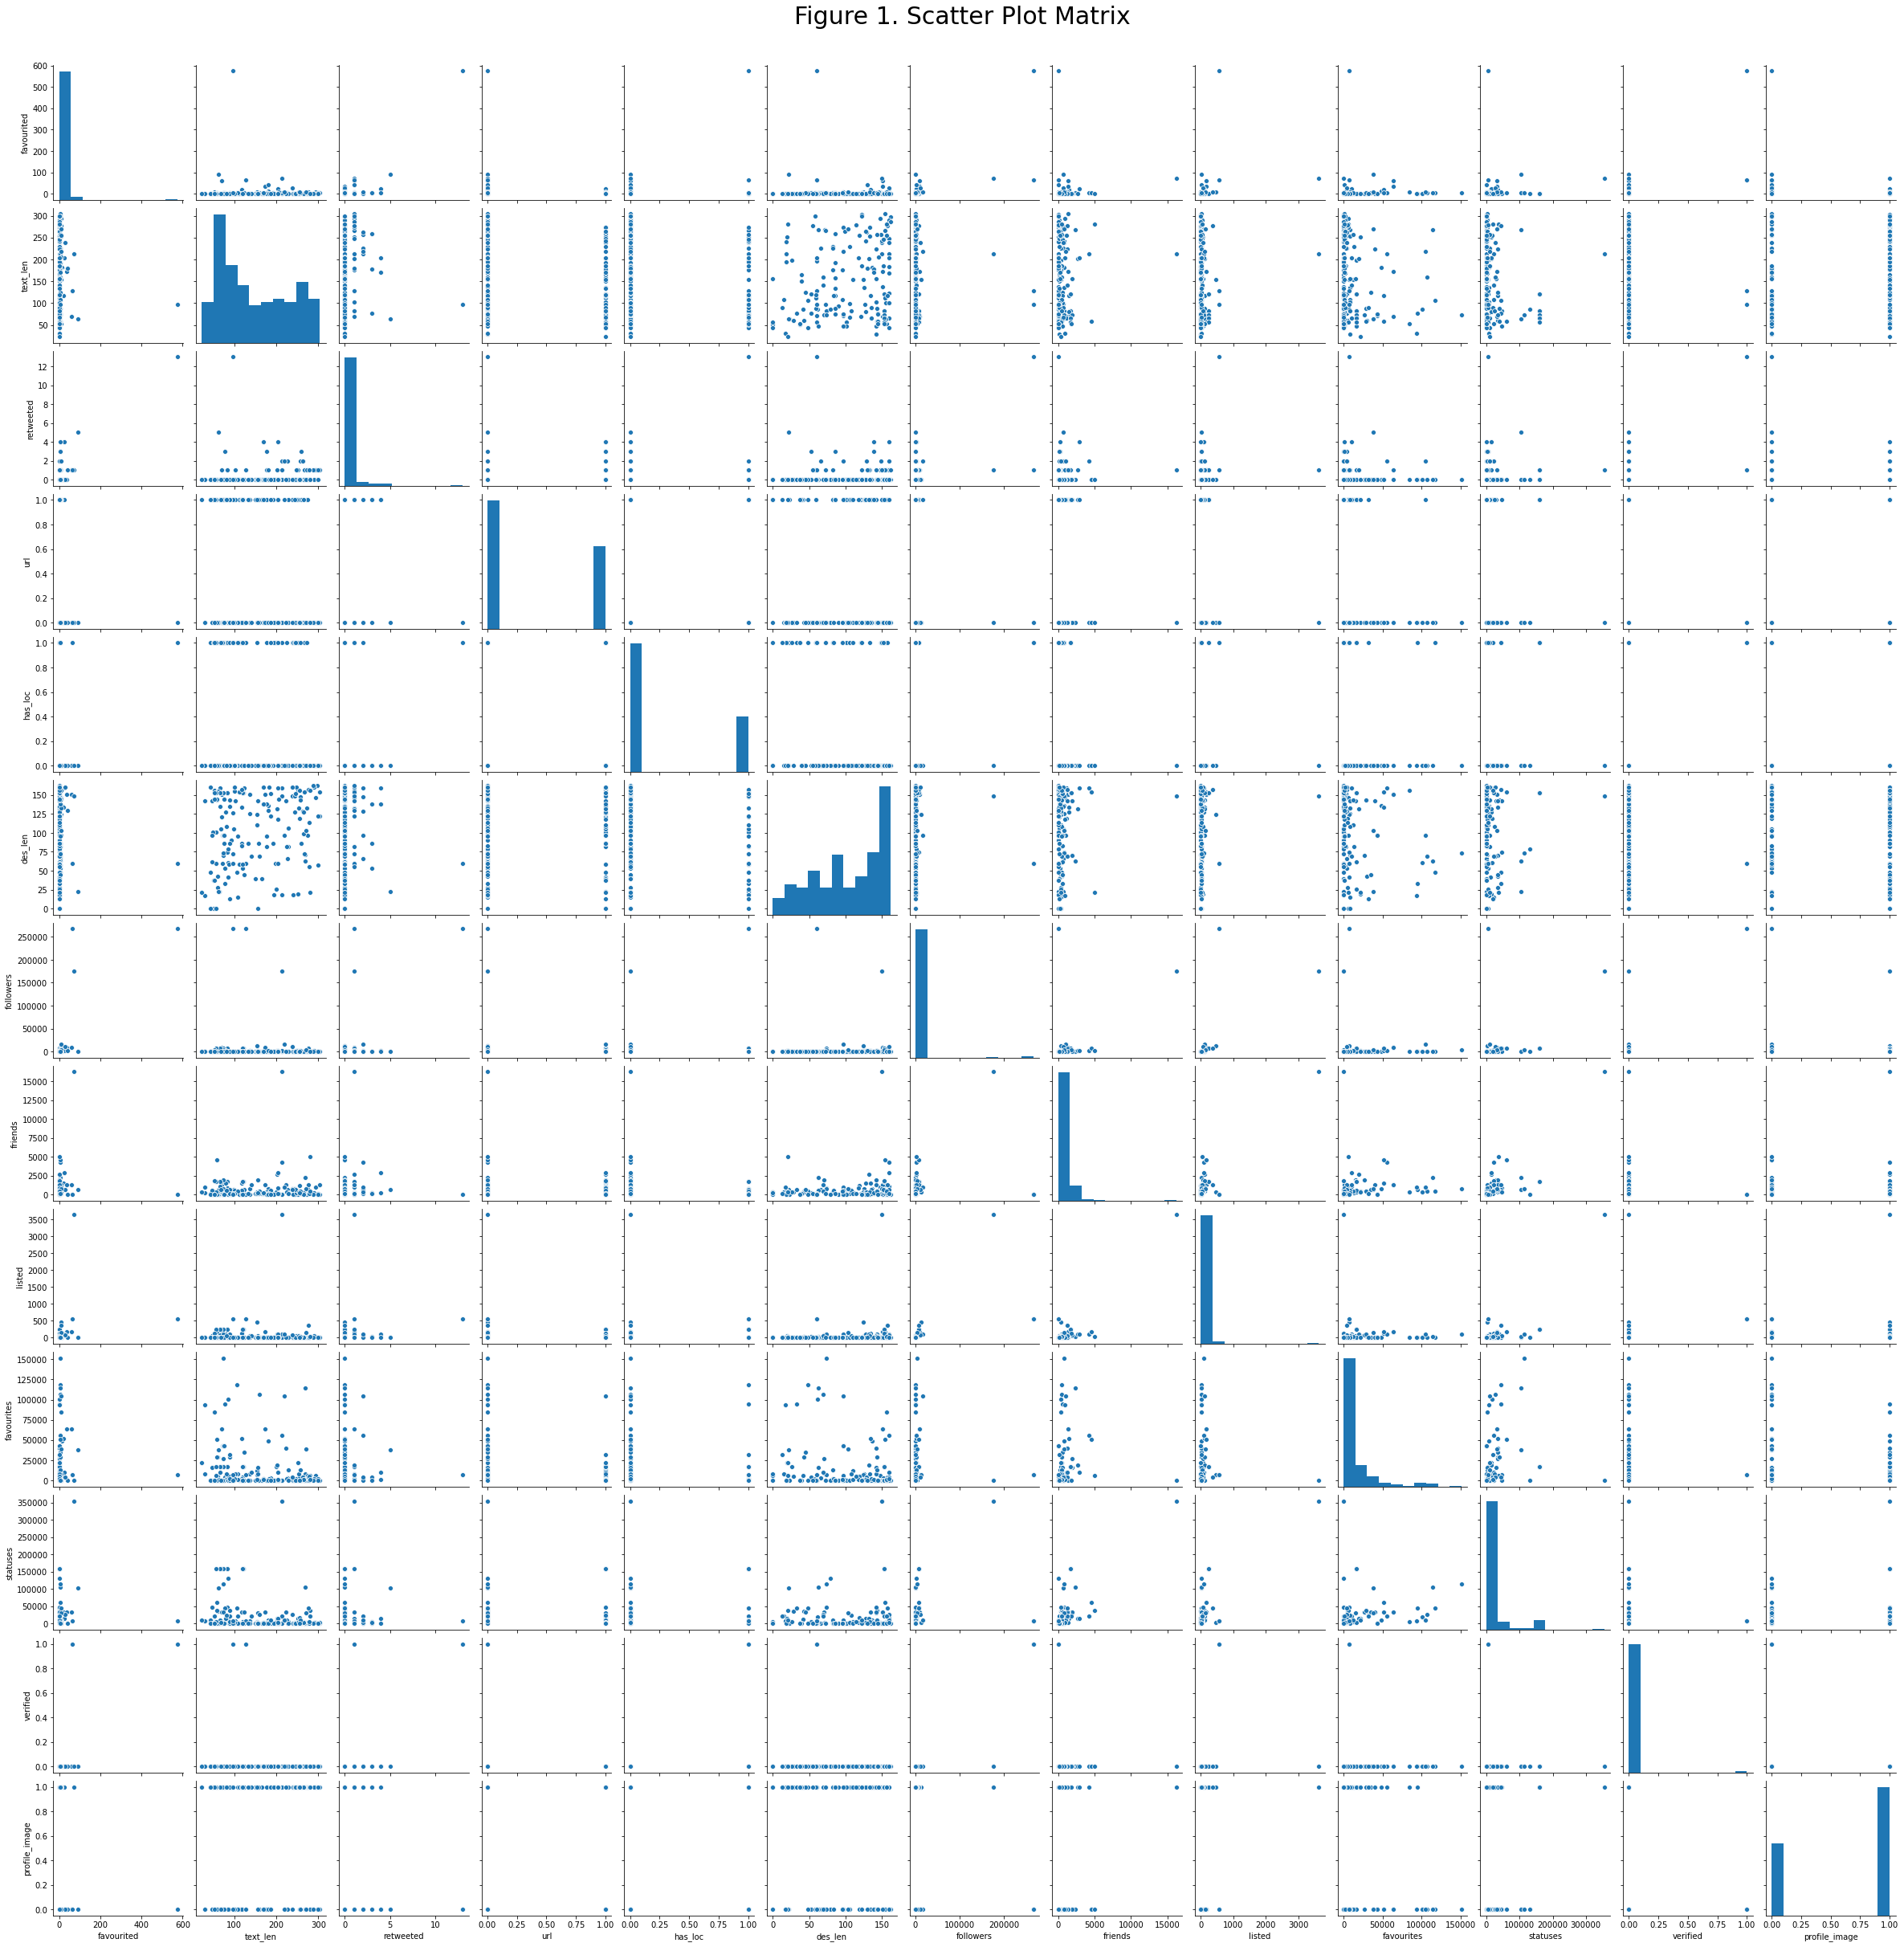

In [15]:
# Scatter Plot Matrix
sns.pairplot(df_features).fig.suptitle('Figure 1. Scatter Plot Matrix',y=1.03,size=30)

To achieve the analytical objective, an OLS regression model will be built to reveal how independent variables will influence favourited count.

To build a solid regression function, the correlation relationships between independent variables are checked to avoid multi-collinearity.

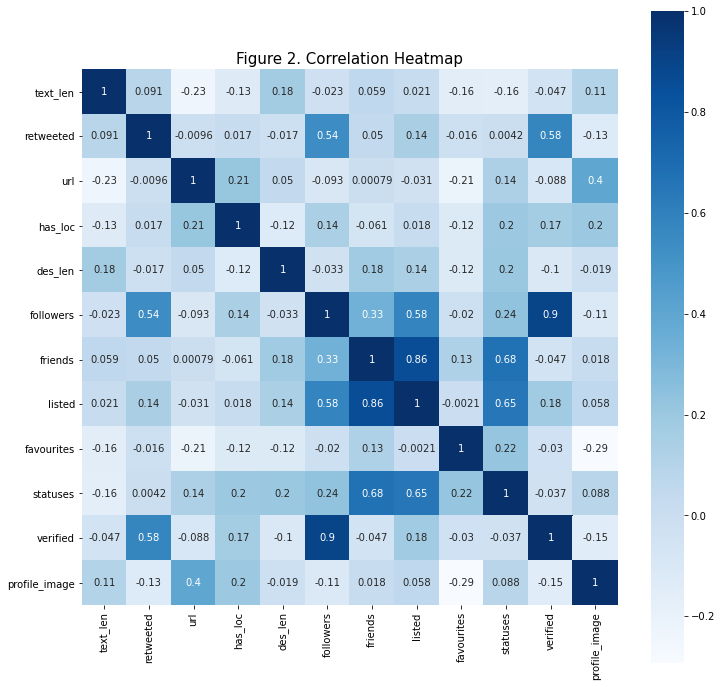

In [16]:
# Check the multi-collinearity
# Heatmap
fig, ax = plt.subplots(figsize=(12,12))

sns.heatmap(df_features[cols].corr(), annot=True, vmax=1, square=True, cmap="Blues").set_title('Figure 2. Correlation Heatmap',size=15)
plt.show()

Because of the high correlation coefficients between 'followers' and 'verified' (0.9), and between 'friends' and 'listed' (0.86), variables 'verified' and 'friends' are removed from independent variables.

In [17]:
# former cols = ['text_len','retweeted','url',
#                'has_loc','des_len','followers','friends','listed','favourites','statuses','verified','profile_image']
# 'friends','verified' exclusive
cols = ['text_len','retweeted','url','has_loc','des_len','followers','listed','favourites','statuses','profile_image']

## 5.4 Model Training

The dataset is split into training data (80%) and testing data (20%).

In [18]:
# Splitting the dataset into training data and testing data
train, test= train_test_split(df_features, test_size = 0.2, random_state=42)

### 5.4.1 Linear Regression

Firstly, a linear regression model is built and the predictions are made on test data.

In [19]:
# set x, y
x_train=train[cols]
y_train=train['favourited']
x_test=test[cols]
y_test=test['favourited']

# OLS
lin_reg = LinearRegression()
res_1 = lin_reg.fit(x_train, y_train)

# coefficients
pd.DataFrame(res_1.coef_,index=cols,columns=['coef'])

,coef
text_len,-0.058286
retweeted,21.863976
url,-9.943835
has_loc,2.259279
des_len,0.009694
followers,0.000648
listed,-0.015574
favourites,0.000018
statuses,-0.000008
profile_image,3.473666


In [20]:
# Predict on test data
y_test_pred_1 = lin_reg.predict(x_test)
mean_squared_error(y_test, y_test_pred_1)

51.13392542673992

The MSE (Mean Squared Error) of this model on test data is 51.13.

### 5.4.2 Polynomial Regression

In Figure 1, it is revealed that some variables have non-linear relationships with the dependent variable, so scatter plots are drawn to check the pairwise relationships. The relationships between 'favourited' and 'retweeted' and 'followers' are closer to quadratic relationships. In this case, quadratic terms of 'retweeted' and 'followers' are added to the regression model.

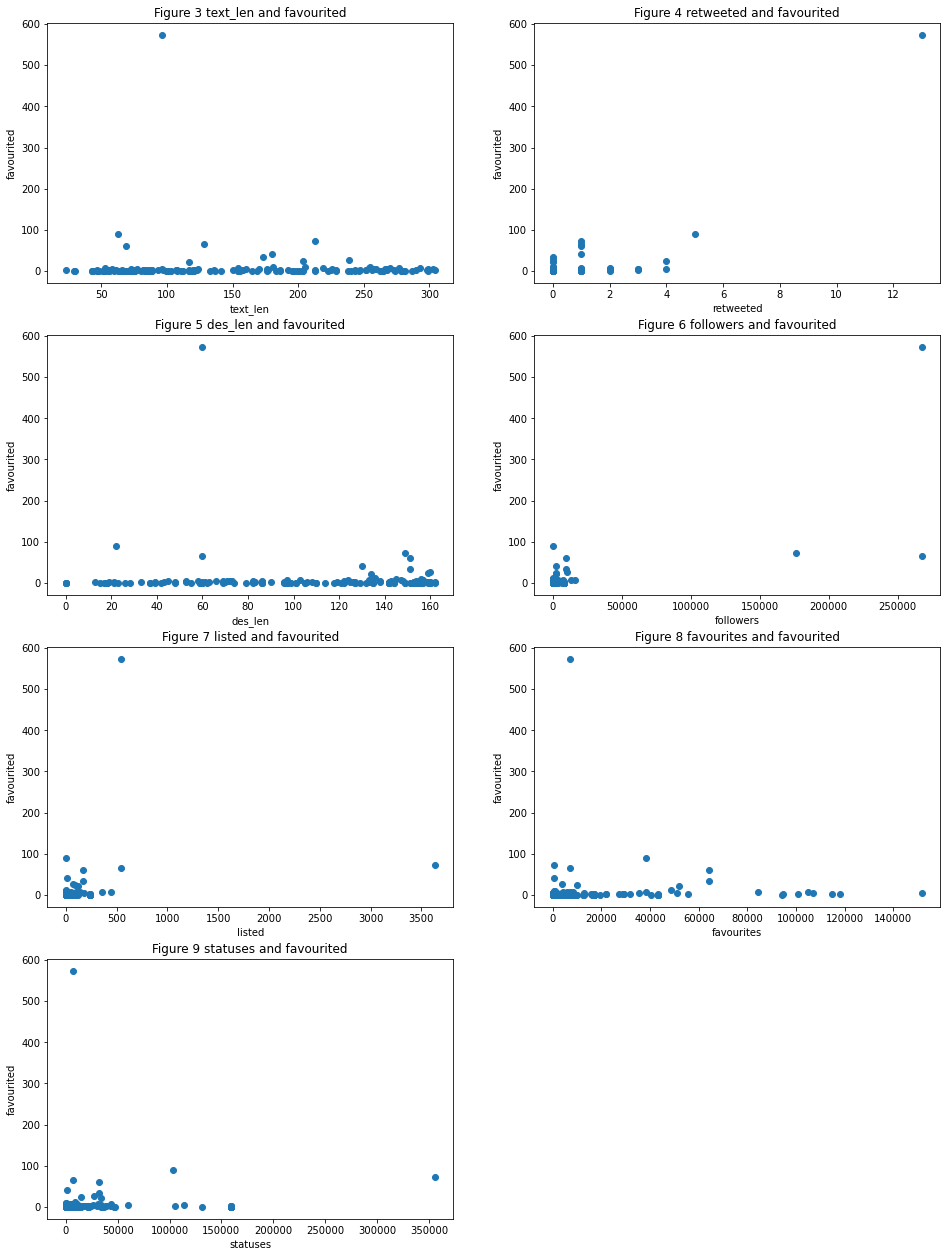

In [21]:
# cols = ['text_len','retweeted','url','has_loc','des_len','followers','listed','favourites','statuses','profile_image']
# continuous variables
continuous = ['text_len','retweeted','des_len','followers','listed','favourites','statuses']
plt.subplots(figsize=(16, 22))
for i in range(7):
    plt.subplot(4, 2, i+1)
    plt.xlabel('{}'.format(continuous[i]))
    plt.ylabel('favourited')
    plt.scatter(df_features[continuous[i]],df_features['favourited'])
    plt.title('Figure {} {} and favourited'.format(i+3,continuous[i]))
plt.show()

In [22]:
# Polynomial regression
poly_f = PolynomialFeatures(degree=2)
# High-order-term variable(s)
poly = ['retweeted','followers']
# one-power variables
one = [i for i in cols if i not in poly]

x_train_poly = np.hstack((poly_f.fit_transform(x_train[poly]),x_train[one]))
x_test_poly = np.hstack((poly_f.fit_transform(x_test[poly]),x_test[one]))

res_2 = lin_reg.fit(x_train_poly, y_train)
# coefficients
pd.DataFrame(res_2.coef_,columns=['coef'])

,coef
0,0.000000e+00
1,-6.935819e+00
2,2.171326e-03
3,3.708942e+00
4,-9.749673e-06
5,-6.997847e-09
6,-6.815643e-03
7,-5.075830e+00
8,-9.253420e-01
9,-2.104702e-04


In [23]:
# Predict test data
y_test_pred_2 = lin_reg.predict(x_test_poly)
mean_squared_error(y_test, y_test_pred_2)

24.86796986566886

The MSE value of this polynomial regression model on test data is greatly reduced, from 51.13 to 24.87, compared with the former one-power linear regression. 

# 6. Conclusion

In this work, 2 schemas of board game data and relevant twitter data are generated in the PostgreSQL database, and this database will be automatically updated weekly by the execution of the DAG in Airflow and Marquez is used to track data origins every time the DAG is triggered. Afterwards twitter data is extracted by SQL and a machine learning pipeline is created. After feature engineering and exploratory analysis, regression models are built to reveal how KOL features will affect the performance of a tweet. It is found that there are non-linear relationships between tweets favourited count and retweeted count, and between tweets favourited count and user followers count.

In the meantime, to achieve the repeatability of this work, history versions of Python scripts and notebooks are added into Git repository lacally, and have been pushed to authors Github account, the log information of the Git repository is shown below.
<img src="repo.png">

The final versions can be accessed via https://github.com/UCL-SOM/data-engineering-21_21-individual-assignment-Rita-Pang. 

# 7. Limitations

Inevitably, this work has some limitations: 
* This work adapts the relational database, which has compact data structures and reduces redundancy. However, these advantages are achieved by sacrificing the flexibility of the database.
* To get more precise and more practical results from the machine learning algorithm, a larger volume of data is required.
* Further development can be exploring more data at board game websites, for example, players' behaviors and comments.

# References

Sawtelle, S., 2017. Building a boardgamegeek.com Data Set with Scraping and APIs in Python. [online] GitHub. Available at: <https://sdsawtelle.github.io/blog/output/boardgamegeek-data-scraping.html> [Accessed 28 April 2021].